<a href="https://colab.research.google.com/github/ali-rabiee/Decoding-Grasping-Movements-Analysis-and-Comparison-of-EEG-and-tEEG/blob/main/ML_4chTripolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import scipy.io.wavfile
import scipy.signal
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt, iirnotch
import zipfile
import warnings
import pywt
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Feature Extraction and Classification

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# This function prepare the X_train, X_test, y_train, y_test
def prepare_data(df, labels, win_size=1501, time_win=(0, None), balance=False):

    X = []
    y = []

    start, end = time_win
    for i in range(0, len(df), win_size):
        x = df[i:i+win_size].values

        # Applying the time window to select a specific range of rows
        x = x[start:end]
        X.append(x)
        y.append(labels[i])

    X, y = np.array(X), np.array(y)

    # Shuffle data
    X, y = shuffle(X, y)
    if balance:
    # Balance the dataset
        oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = oversampler.fit_resample(X.reshape(-1, X.shape[1]*X.shape[2]), y)
        X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled, y_resampled
    else:
        return X, y


def report_classification_metrics(y_true, y_pred, average_type='macro'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_type)
    recall = recall_score(y_true, y_pred, average=average_type)
    f1 = f1_score(y_true, y_pred, average=average_type)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

def extract_statistical_features_from_amplitude(coefficients):
    """Extract statistical features from the amplitude of wavelet coefficients."""
    amplitude = np.abs(coefficients.flatten())  # Get the amplitude and flatten

    # Extract features from amplitude
    mean_amp = np.mean(amplitude)
    variance_amp = np.var(amplitude)
    skewness_amp = skew(amplitude)
    kurtosis_amp = kurtosis(amplitude)

    return [mean_amp, variance_amp, skewness_amp, kurtosis_amp]

def get_amplitude_features_for_data(X, wavelet='cmor', max_scale=50):
    all_features = []

    # For each instance in X
    for instance in X:
        instance_features = []

        # For each channel-frequency band pair in the instance
        for column in range(instance.shape[1]):
            coefficients, _ = pywt.cwt(instance[:, column], scales=np.arange(1, max_scale+1), wavelet=wavelet)

            # Extract statistical features from the amplitude
            amp_features = extract_statistical_features_from_amplitude(coefficients)
            instance_features.extend(amp_features)

        all_features.append(instance_features)

    return np.array(all_features)

## Visualizing the Features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def average_wavelet_coefficients(X, wavelet='morl', scales=np.arange(1, 128), sr=250):
    coefficients_list = []

    # For each instance in X
    for instance in X:
        instance_coefficients = []

        # For each channel in the instance
        for column in range(instance.shape[1]):
            coefficients, freqs = pywt.cwt(instance[:, column], scales=scales, wavelet=wavelet, sampling_period=1/sr)
            instance_coefficients.append(np.abs(coefficients)**2)

        coefficients_list.append(instance_coefficients)

    # Average across all instances
    avg_coefficients = np.mean(coefficients_list, axis=0)
    return avg_coefficients, freqs

def scale_to_freq(scale, sampling_rate=250.0, cf=0.8491):
    """Converts wavelet scale to frequency."""
    return cf / scale * sampling_rate

In [ ]:
from preprocessing import *

# Set the path for this subject
path = "/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject6/task_3"

df_2 = read_data_and_preprocessing(path, events=[1], denoise=0, detrend=False, low_f=1, high_f=40, FreqBands=False, minmax=False, zscore=True)

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))

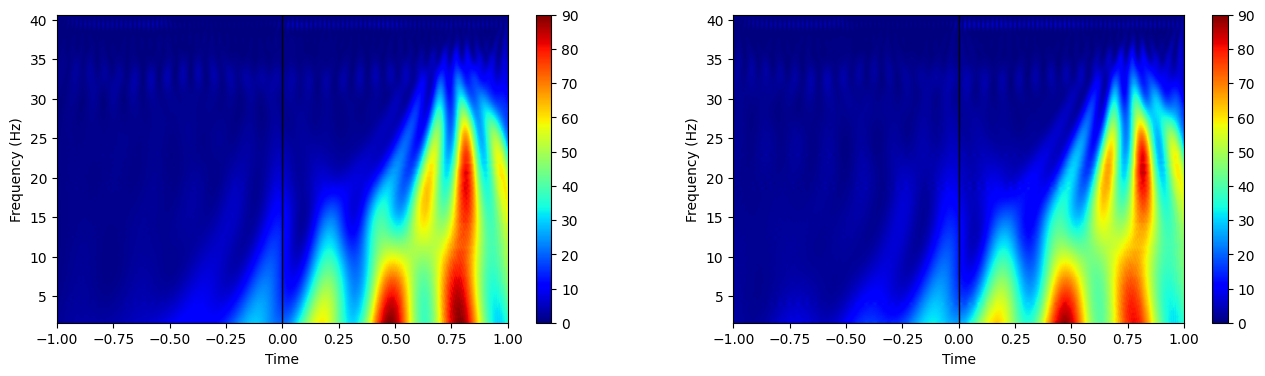

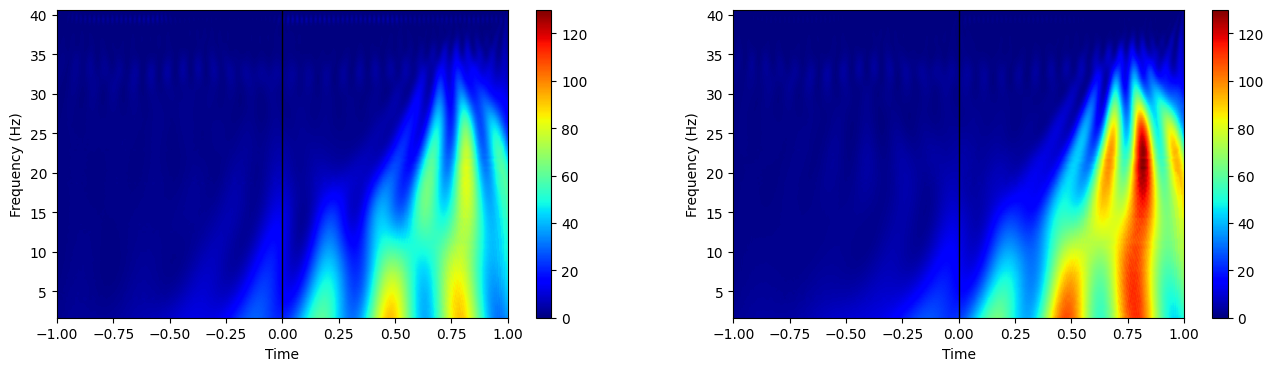

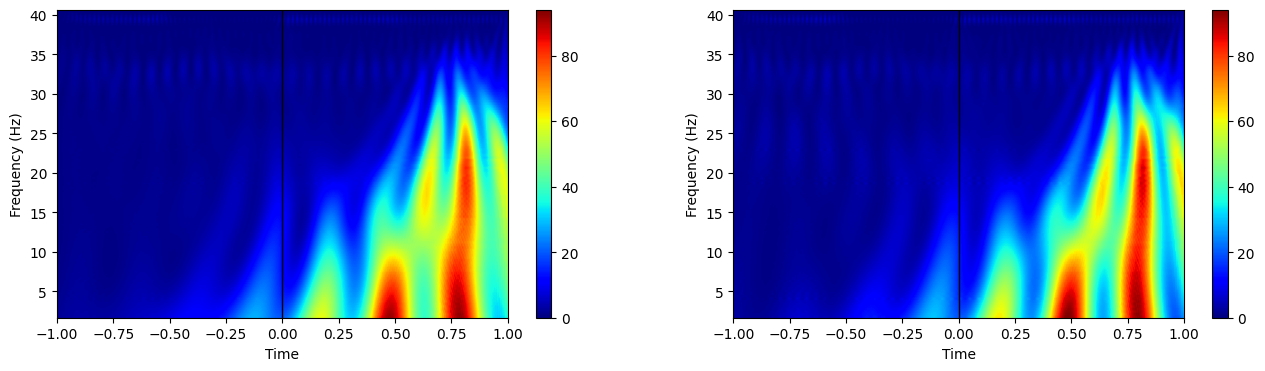

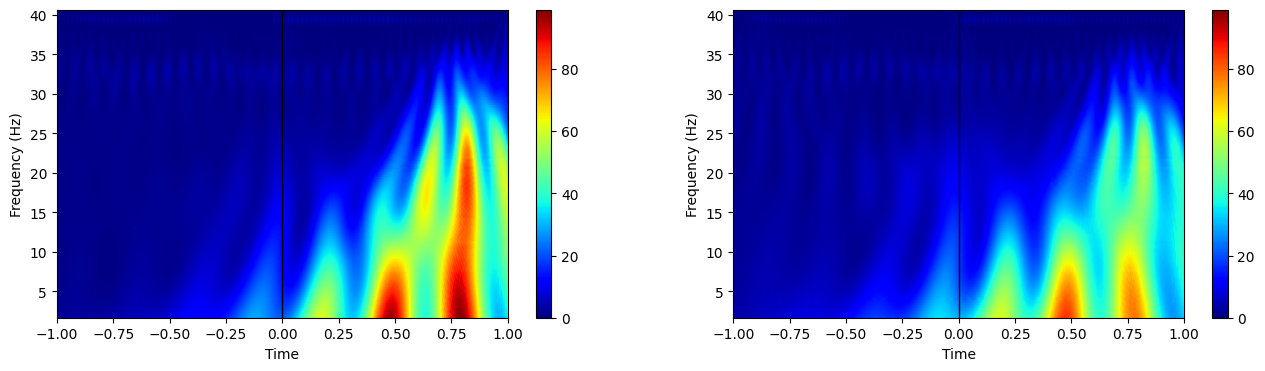

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)
# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    # im1.set_clim(0,60)

    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    # im2.set_clim(0, 60)

    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

In [ ]:
from preprocessing import *

# Set the path for this subject
path = "/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject6/task_3"

df_2 = read_data_and_preprocessing(path, events=[2], denoise=0, detrend=False, low_f=1, high_f=30, FreqBands=False, minmax=False, zscore=True)

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((601, 1101)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((601, 1101)))

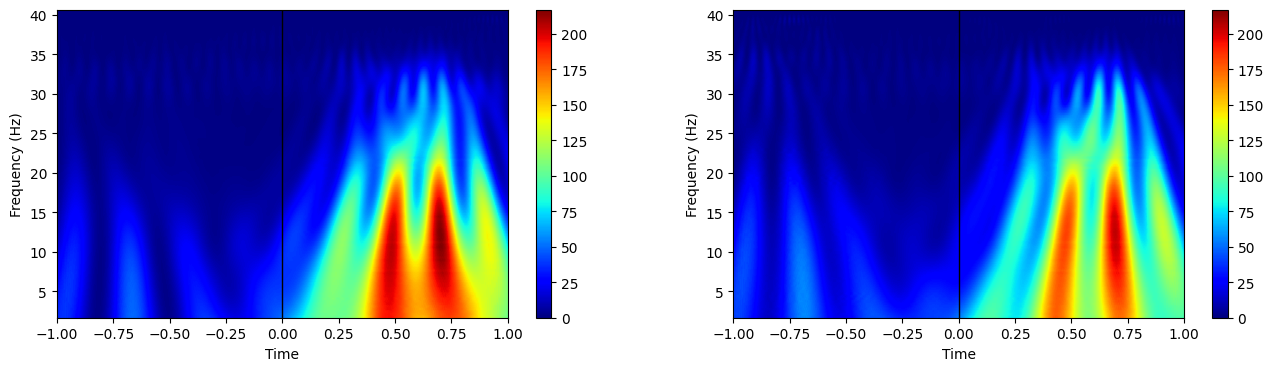

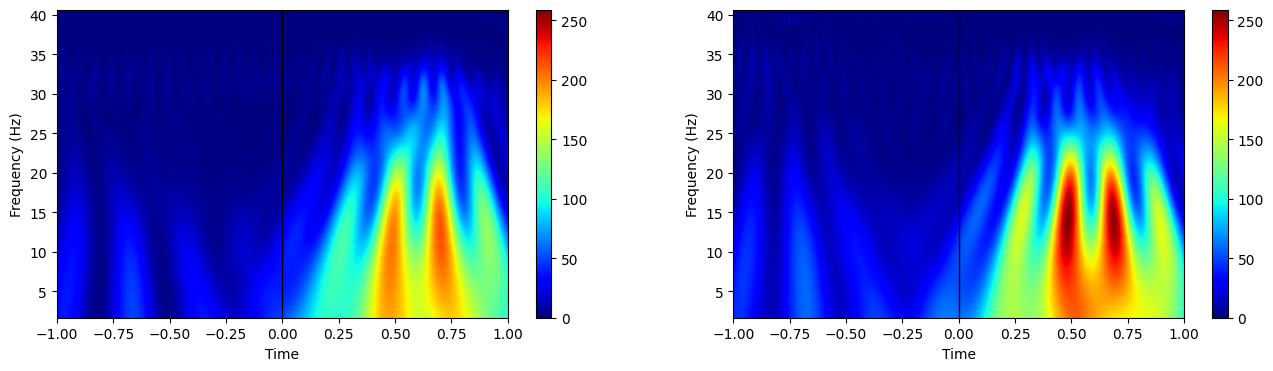

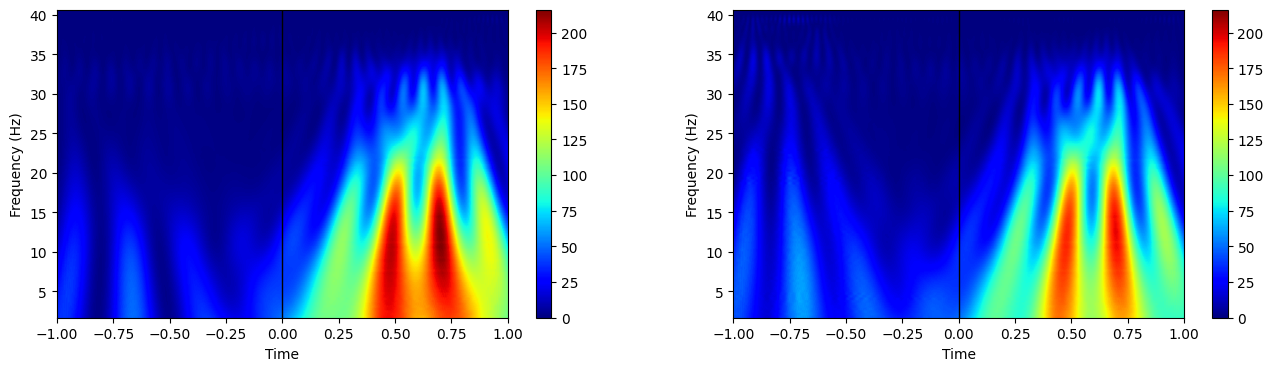

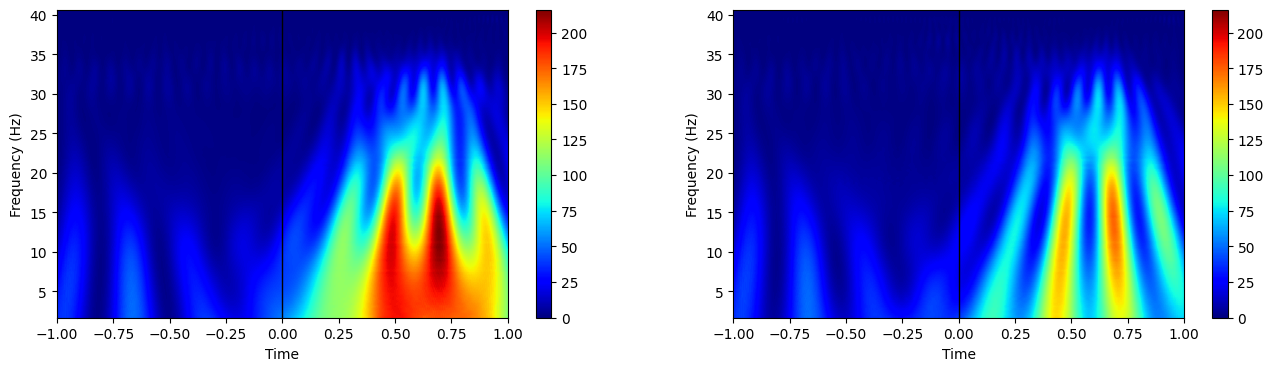

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)

# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

In [ ]:
from preprocessing import *

# Set the path for this subject
path = "/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject6/task_3"

df_2 = read_data_and_preprocessing(path, events=[0], denoise=0, detrend=False, low_f=1, high_f=30, FreqBands=False, minmax=False, zscore=True, baseline_correction=(2000, 2751))

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((751, 1251)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((751, 1251)))

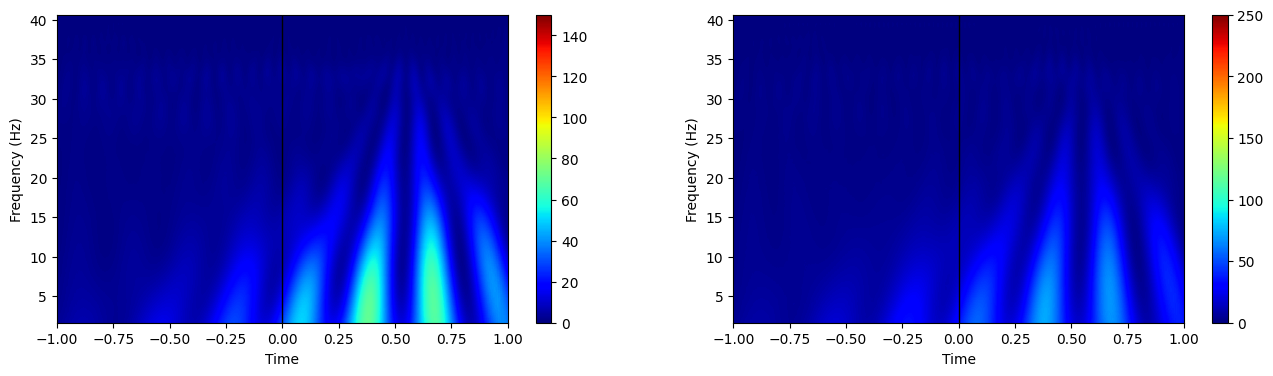

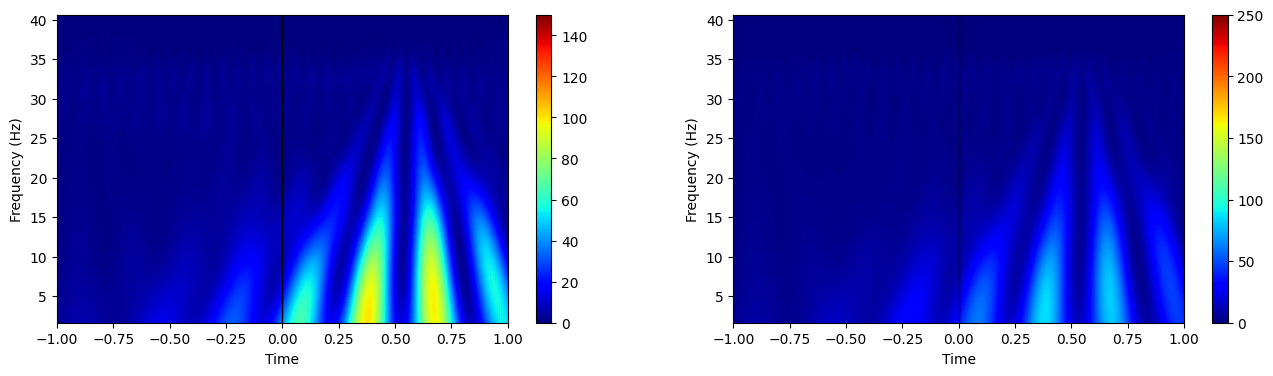

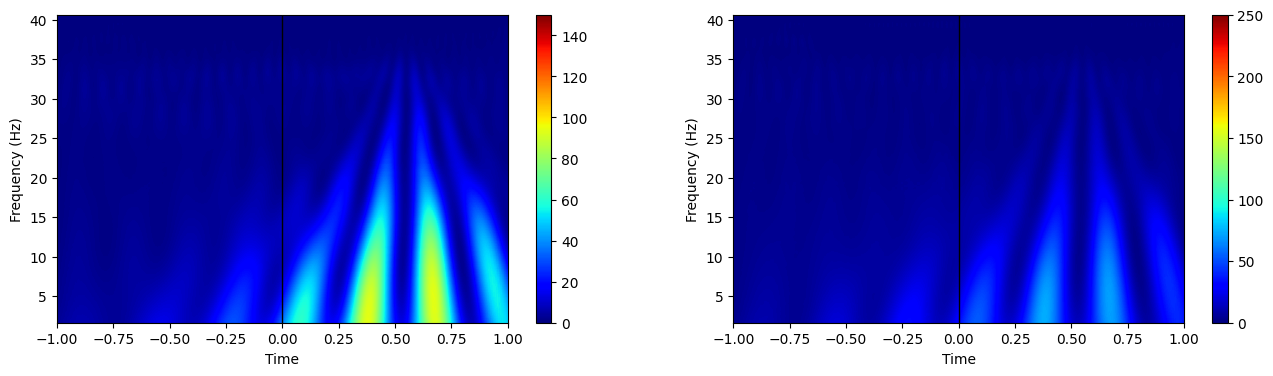

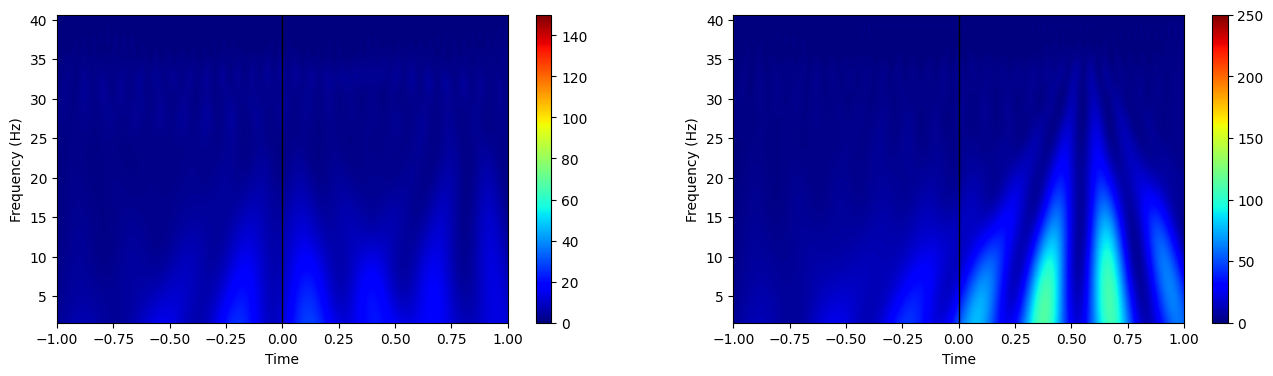

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)

# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, 150)
    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, 250)
    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

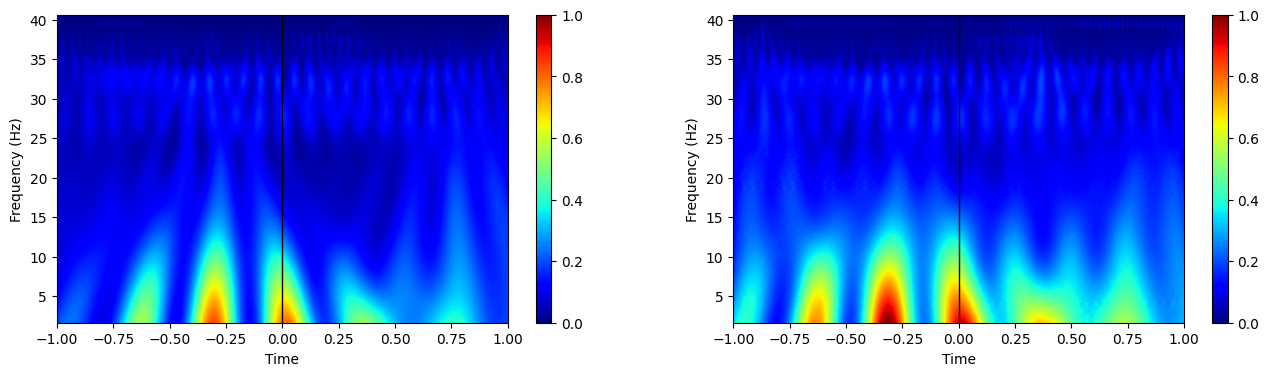

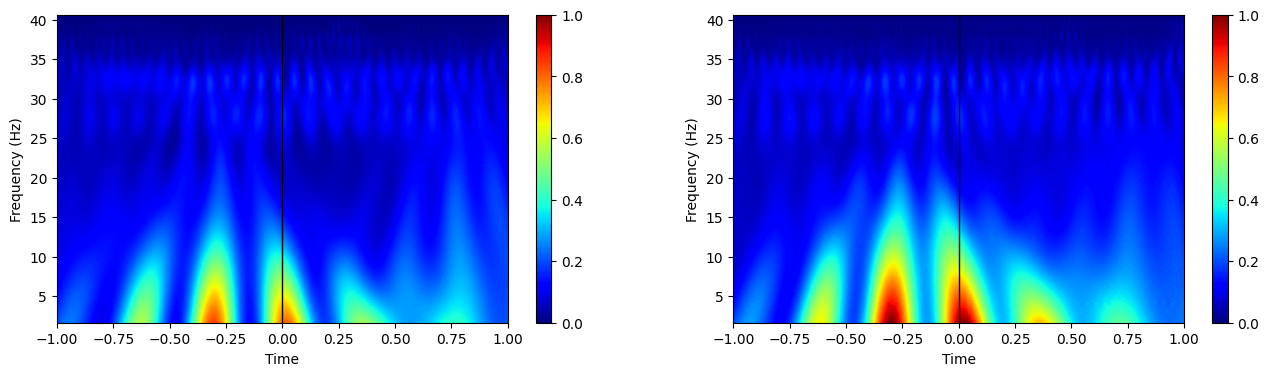

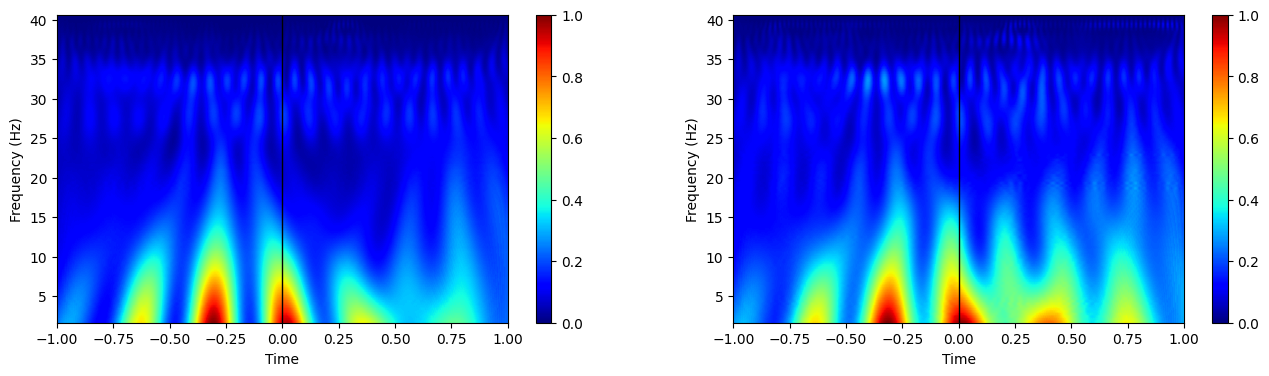

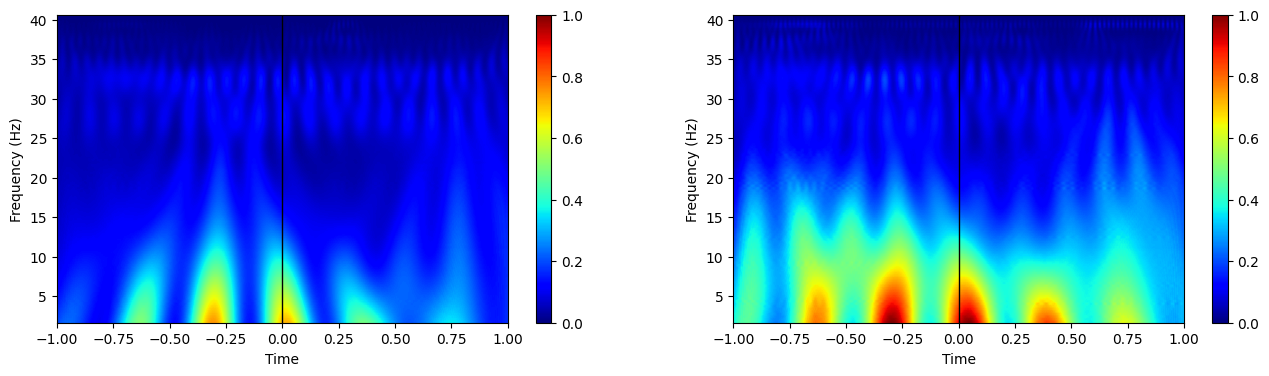

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)

# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # Normalize the coefficients by the maximum value from both datasets
    max_coeff = max(eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max())
    eeg_normalized = eeg_avg_coeffs[ch] / max_coeff
    teeg_normalized = teeg_avg_coeffs[ch] / max_coeff

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    # Plot EEG
    im1 = axes[0].imshow(eeg_normalized, aspect='auto', cmap='jet', extent=extent)
    # im1.set_clim(0, 1)  # Set color limits to 0 and 1 for normalization
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    axes[0].axvline(0, color='black', linewidth=1)

    # Plot TEEG
    im2 = axes[1].imshow(teeg_normalized, aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, 1)  # Set color limits to 0 and 1 for normalization
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

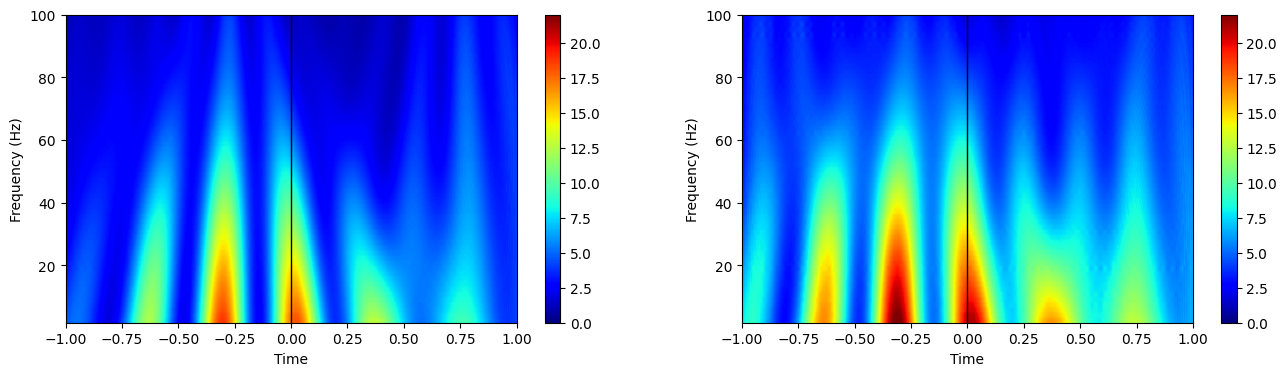

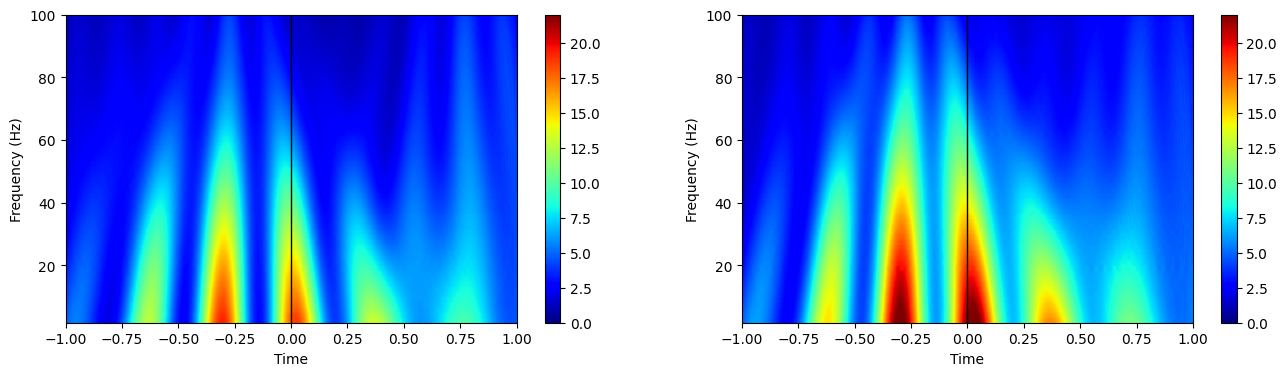

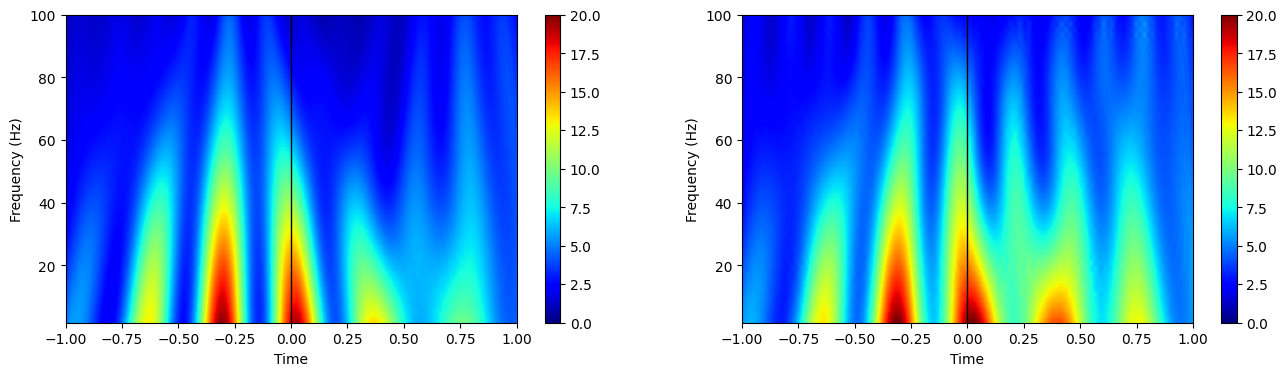

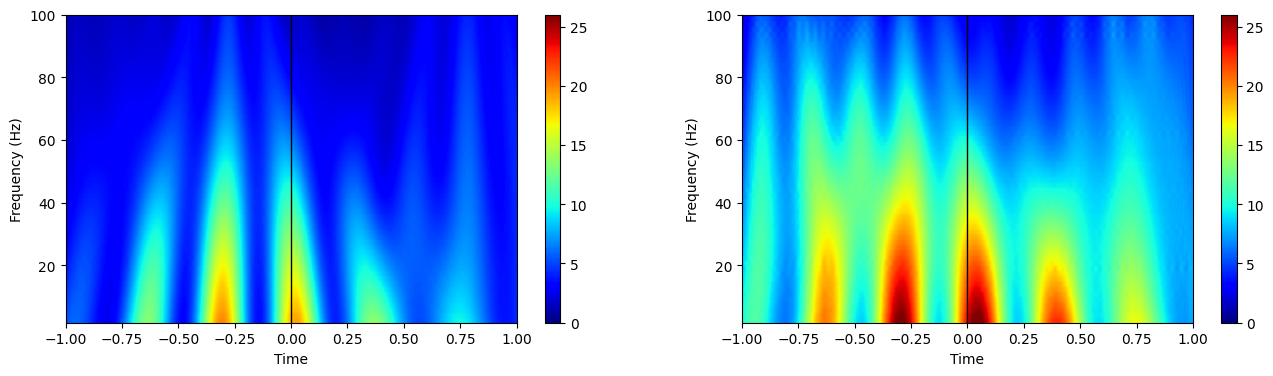

In [ ]:
googimport numpy as np
import matplotlib.pyplot as plt
import pywt

def average_wavelet_coefficients(X, wavelet='morl', max_scale=127):
    coefficients_list = []

    # For each instance in X
    for instance in X:
        instance_coefficients = []

        # For each channel in the instance
        for column in range(instance.shape[1]):
            coefficients, freqs = pywt.cwt(instance[:, column], scales=np.arange(1, max_scale+1), wavelet=wavelet)
            instance_coefficients.append(np.abs(coefficients)**2)

        coefficients_list.append(instance_coefficients)

    # Average across all instances
    avg_coefficients = np.mean(coefficients_list, axis=0)
    return avg_coefficients

eeg_avg_coeffs = average_wavelet_coefficients(X_eeg_2)
teeg_avg_coeffs = average_wavelet_coefficients(X_tcre_2)

def scale_to_freq(scale, sampling_rate=250.0, cf=0.8491):
    """Converts wavelet scale to frequency."""
    return cf / scale * sampling_rate

# Convert scales to frequencies
frequencies = scale_to_freq(np.arange(1, 128+1))

# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    axes[0].set_ylim([frequencies[-1], 100])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    axes[1].set_ylim([frequencies[-1], 100])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()


In [ ]:
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    n_signal = len(data)  # Change from data.shape[1] to len(data)
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    signal_fft = np.fft.fft(data, n_convolution)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)

    convolution_result_fft = signal_fft * wavelet_fft
    convolution_result_ifft = np.fft.ifft(convolution_result_fft)

    # Removing edge artifacts and making the length same as the input data
    convolution_result = convolution_result_ifft[int(n_wavelet / 2): -int(n_wavelet / 2)]

    return convolution_result


# Test

In [ ]:
import os
from preprocessing import *

# Set the path for this subject
path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject3/task_3"

df = read_data_and_preprocessing(path, events=[0, 1, 2], denoise=50, FreqBands=True)

labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)

df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                    'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                    'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                    'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                    'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                    'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                    'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

# Get amplitude-based features from wavelet transform
features_eeg = get_amplitude_features_for_data(X_eeg)
features_tcre = get_amplitude_features_for_data(X_tcre)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for k-fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(C=50),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(n_estimators=20, learning_rate=0.05),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(C=50),
}



In [ ]:
clf = LogisticRegression(C=50)

accuracies_eeg = []
accuracies_tcre = []

for train_index, test_index in kf.split(features_eeg, y):
            X_train, X_test = features_eeg[train_index], features_eeg[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies_eeg.append(accuracy)

avg_accuracy_eeg = sum(accuracies_eeg) / n_splits

for train_index, test_index in kf.split(features_tcre, y):
            X_train, X_test = features_tcre[train_index], features_tcre[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies_tcre.append(accuracy)

avg_accuracy_tcre = sum(accuracies_tcre) / n_splits

print(f"EEG: {avg_accuracy_eeg}")
print(f"TCRE: {avg_accuracy_tcre}")

EEG: 0.7324358974358974
TCRE: 0.7728205128205128


# Classification

## Text to table

In [ ]:
# Initialize the nested dictionary structure
subjects = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]
scenarios = ["EEG", "Tripolar"]
models = ["Random Forest", "SVM", "XGBoost", "LDA"]
file_name = "results.txt"
accuracies_dict = {}
for subj in subjects:
    accuracies_dict[subj] = {}
    for scenario in scenarios:
        accuracies_dict[subj][scenario] = {}
        for model in models:
            accuracies_dict[subj][scenario][model] = None

# Fill the dictionary with accuracies from the text file
with open(file_name, "r") as file:
    lines = file.readlines()

current_subject = None
current_model = None
current_scn = None

for line in lines:
    # Identify the subject
    if "Subject" in line:
        current_subject = f"S{line.split('Subject')[-1].strip()}"
        continue
    # Identify the model
    if any(model in line for model in models):
        current_model = line.split(" - ")[1].strip().replace(":", "")

    if "EEG" in line:
        current_scn = "EEG"
        continue
    if "Tripolar" in line:
        current_scn = "Tripolar"
        continue
    if "Average Accuracy" in line:
        accuracy = float(line.split(":")[-1].replace("%", "").strip())
        accuracies_dict[current_subject][current_scn][current_model] = accuracy
        continue

# Convert nested dictionary to DataFrame for EEG
df_eeg = pd.DataFrame({subject: accuracies_dict[subject]['EEG'] for subject in subjects}).transpose()
df_tripolar = pd.DataFrame({subject: accuracies_dict[subject]['Tripolar'] for subject in subjects}).transpose()

# Combine EEG and Tripolar DataFrames
df_combined = pd.concat([df_eeg, df_tripolar], axis=1, keys=['EEG Acc(%)', 'TCRE Acc(%)'])

# Calculate the mean for each column and append to the DataFrame
mean_values = df_combined.mean(axis=0)
df_combined.loc["Mean"] = mean_values

# Export to Excel
df_combined.to_excel("multiclass.xlsx", engine='openpyxl')
print("Data exported to accuracies.xlsx with mean values.")

Data exported to accuracies.xlsx with mean values.


## Multiclass Classification

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from preprocessing import *
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for k-fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=1),
    "SVM": SVC(C=20),
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(n_estimators=1, learning_rate=0.05),
    "LDA": LinearDiscriminantAnalysis(),
    # "Logistic Regression": LogisticRegression(C=50),
}

# Loop through subjects
for subject_num in range(1, 11):
    print(f"\nSubject{subject_num}\n====================")
    # Set the path for this subject
    path = f"/content/drive/Shared drives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1, 2], low_f=1, high_f=40, denoise=0, detrend=False, minmax=True, zscore=False, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y_eeg = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)), balance=False)
    X_tcre, y_tcre = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)), balance=True)

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": [features_eeg, y_eeg], "Tripolar": [features_tcre, y_tcre]}

    # total_confusion_matrix = np.zeros((3, 3))

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():

        # clf_confusion_matrix = np.zeros((3, 3))

        for data_name, data in data_types.items():

            accuracies = []
            features, y = data

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

                # clf_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")


    # total_confusion_matrix += clf_confusion_matrix / n_splits

# After all subjects and classifiers are processed, average the total confusion matrix
# average_confusion_matrix = total_confusion_matrix / (len(classifiers) * 10)
# print(average_confusion_matrix)


Subject1

 EEG - Random Forest:
Average Accuracy: 38.67%

 Tripolar - Random Forest:
Average Accuracy: 63.70%

 EEG - SVM:
Average Accuracy: 57.33%

 Tripolar - SVM:
Average Accuracy: 51.85%

 EEG - XGBoost:
Average Accuracy: 41.33%

 Tripolar - XGBoost:
Average Accuracy: 79.26%

 EEG - LDA:
Average Accuracy: 20.00%

 Tripolar - LDA:
Average Accuracy: 72.59%

Subject2

 EEG - Random Forest:
Average Accuracy: 36.25%

 Tripolar - Random Forest:
Average Accuracy: 70.91%

 EEG - SVM:
Average Accuracy: 56.25%

 Tripolar - SVM:
Average Accuracy: 58.28%

 EEG - XGBoost:
Average Accuracy: 47.50%

 Tripolar - XGBoost:
Average Accuracy: 76.31%

 EEG - LDA:
Average Accuracy: 33.75%

 Tripolar - LDA:
Average Accuracy: 63.94%

Subject3

 EEG - Random Forest:
Average Accuracy: 47.27%

 Tripolar - Random Forest:
Average Accuracy: 76.78%

 EEG - SVM:
Average Accuracy: 60.91%

 Tripolar - SVM:
Average Accuracy: 68.12%

 EEG - XGBoost:
Average Accuracy: 55.45%

 Tripolar - XGBoost:
Average Accuracy: 76

## Binary (No-movement vs Power Grasp)

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from preprocessing import *

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(C=100),
    "XGBoost": xgb.XGBClassifier(num_classes=2),
    "LDA": LinearDiscriminantAnalysis()
}

# Loop through subjects
for subject_num in range(1, 11):
    print(f"\nSubject{subject_num}\n====================")
    # Set the path for this subject
    path = f"/content/drive/Shared drives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1], low_f=1, high_f=40, denoise=50, detrend=False, minmax=False, zscore=True, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y_eeg = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)), balance=False)
    X_tcre, y_tcre = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)), balance=True)

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": [features_eeg, y_eeg], "Tripolar": [features_tcre, y_tcre]}

    # total_confusion_matrix = np.zeros((3, 3))

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():

        # clf_confusion_matrix = np.zeros((3, 3))

        for data_name, data in data_types.items():

            accuracies = []
            features, y = data

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

                # clf_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")


    # total_confusion_matrix += clf_confusion_matrix / n_splits

# After all subjects and classifiers are processed, average the total confusion matrix
# average_confusion_matrix = total_confusion_matrix / (len(classifiers) * 10)
# print(average_confusion_matrix)


Subject1

 EEG - Random Forest:
Average Accuracy: 70.00%

 Tripolar - Random Forest:
Average Accuracy: 90.00%

 EEG - SVM:
Average Accuracy: 75.00%

 Tripolar - SVM:
Average Accuracy: 75.56%

 EEG - XGBoost:
Average Accuracy: 73.33%

 Tripolar - XGBoost:
Average Accuracy: 88.89%

 EEG - LDA:
Average Accuracy: 51.67%

 Tripolar - LDA:
Average Accuracy: 78.89%

Subject2

 EEG - Random Forest:
Average Accuracy: 82.82%

 Tripolar - Random Forest:
Average Accuracy: 87.42%

 EEG - SVM:
Average Accuracy: 76.54%

 Tripolar - SVM:
Average Accuracy: 85.42%

 EEG - XGBoost:
Average Accuracy: 84.36%

 Tripolar - XGBoost:
Average Accuracy: 84.32%

 EEG - LDA:
Average Accuracy: 56.28%

 Tripolar - LDA:
Average Accuracy: 72.89%

Subject3

 EEG - Random Forest:
Average Accuracy: 71.76%

 Tripolar - Random Forest:
Average Accuracy: 92.36%

 EEG - SVM:
Average Accuracy: 74.05%

 Tripolar - SVM:
Average Accuracy: 83.30%

 EEG - XGBoost:
Average Accuracy: 76.34%

 Tripolar - XGBoost:
Average Accuracy: 90

## Binary (No-move vs Precision)

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from preprocessing import *

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(C=100),
    "XGBoost": xgb.XGBClassifier(num_classes=2),
    "LDA": LinearDiscriminantAnalysis()
}

# Loop through subjects
for subject_num in range(1, 11):
    print(f"\nSubject{subject_num}\n====================")
    # Set the path for this subject
    path = f"/content/drive/Shared drives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 2], low_f=1, high_f=40, denoise=50, detrend=False, minmax=False, zscore=True, FreqBands=True)

    labels = df["events"].to_list()
    labels = [1 if label == 2 else label for label in labels]
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y_eeg = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)), balance=False)
    X_tcre, y_tcre = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)), balance=True)

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": [features_eeg, y_eeg], "Tripolar": [features_tcre, y_tcre]}

    # total_confusion_matrix = np.zeros((3, 3))

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():

        # clf_confusion_matrix = np.zeros((3, 3))

        for data_name, data in data_types.items():

            accuracies = []
            features, y = data

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

                # clf_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")


    # total_confusion_matrix += clf_confusion_matrix / n_splits

# After all subjects and classifiers are processed, average the total confusion matrix
# average_confusion_matrix = total_confusion_matrix / (len(classifiers) * 10)
# print(average_confusion_matrix)


Subject1

 EEG - Random Forest:
Average Accuracy: 76.67%

 Tripolar - Random Forest:
Average Accuracy: 90.00%

 EEG - SVM:
Average Accuracy: 78.33%

 Tripolar - SVM:
Average Accuracy: 85.56%

 EEG - XGBoost:
Average Accuracy: 78.33%

 Tripolar - XGBoost:
Average Accuracy: 90.00%

 EEG - LDA:
Average Accuracy: 51.67%

 Tripolar - LDA:
Average Accuracy: 71.11%

Subject2

 EEG - Random Forest:
Average Accuracy: 78.08%

 Tripolar - Random Forest:
Average Accuracy: 88.53%

 EEG - SVM:
Average Accuracy: 62.56%

 Tripolar - SVM:
Average Accuracy: 82.21%

 EEG - XGBoost:
Average Accuracy: 67.18%

 Tripolar - XGBoost:
Average Accuracy: 84.37%

 EEG - LDA:
Average Accuracy: 53.21%

 Tripolar - LDA:
Average Accuracy: 76.11%

Subject3

 EEG - Random Forest:
Average Accuracy: 75.03%

 Tripolar - Random Forest:
Average Accuracy: 93.22%

 EEG - SVM:
Average Accuracy: 62.35%

 Tripolar - SVM:
Average Accuracy: 82.56%

 EEG - XGBoost:
Average Accuracy: 66.99%

 Tripolar - XGBoost:
Average Accuracy: 93

## Binary (Power vs Precision)

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from preprocessing import *
# Define the number of splits for k-fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(C=100),
    "XGBoost": xgb.XGBClassifier(num_classes=2),
    "LDA": LinearDiscriminantAnalysis()
}

# Loop through subjects
for subject_num in range(1, 11):
    print(f"\nSubject{subject_num}\n====================")
    # Set the path for this subject
    path = f"/content/drive/Shared drives/TNLabAnalysis_VisionBasedGrasping/Tripolar_Unicorn_4Ch/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1, 2], low_f=1, high_f=40, denoise=0, detrend=False, minmax=True, zscore=False, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y_eeg = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)), balance=False)
    X_tcre, y_tcre = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)), balance=True)

    indices = np.where(y_eeg != 2)[0]
    X_eeg, y_eeg = X_eeg[indices], y_eeg[indices]

    indices = np.where(y_tcre != 2)[0]
    X_tcre, y_tcre = X_tcre[indices], y_tcre[indices]

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": [features_eeg, y_eeg], "Tripolar": [features_tcre, y_tcre]}

    # total_confusion_matrix = np.zeros((3, 3))

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():

        # clf_confusion_matrix = np.zeros((3, 3))

        for data_name, data in data_types.items():

            accuracies = []
            features, y = data

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

                # clf_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")


    # total_confusion_matrix += clf_confusion_matrix / n_splits

# After all subjects and classifiers are processed, average the total confusion matrix
# average_confusion_matrix = total_confusion_matrix / (len(classifiers) * 10)
# print(average_confusion_matrix)


Subject1

 EEG - Random Forest:
Average Accuracy: 65.00%

 Tripolar - Random Forest:
Average Accuracy: 82.22%

 EEG - SVM:
Average Accuracy: 73.33%

 Tripolar - SVM:
Average Accuracy: 76.67%

 EEG - XGBoost:
Average Accuracy: 63.33%

 Tripolar - XGBoost:
Average Accuracy: 78.89%

 EEG - LDA:
Average Accuracy: 40.00%

 Tripolar - LDA:
Average Accuracy: 67.78%

Subject2

 EEG - Random Forest:
Average Accuracy: 64.10%

 Tripolar - Random Forest:
Average Accuracy: 87.47%

 EEG - SVM:
Average Accuracy: 67.18%

 Tripolar - SVM:
Average Accuracy: 71.79%

 EEG - XGBoost:
Average Accuracy: 61.03%

 Tripolar - XGBoost:
Average Accuracy: 84.32%

 EEG - LDA:
Average Accuracy: 48.21%

 Tripolar - LDA:
Average Accuracy: 72.74%

Subject3

 EEG - Random Forest:
Average Accuracy: 73.86%

 Tripolar - Random Forest:
Average Accuracy: 89.37%

 EEG - SVM:
Average Accuracy: 78.30%

 Tripolar - SVM:
Average Accuracy: 79.60%

 EEG - XGBoost:
Average Accuracy: 71.57%

 Tripolar - XGBoost:
Average Accuracy: 87